# Estadísticas Scopus UTB

Este notebook tiene como objetivo generar un algoritmo que permita obetener tablas resumen de estadísticas para investigadores de la Universidad, en términos de sus productividades e investigaciones y trabajos publicados, además categorizando en artículos para cuartiles Q1, Q2, Q3, Q4 y/o Sin Cuartil.

**Desarrollo**: D. Sierra Porta (2025)

## ¿Qué es necesario?
Este script necesita tres archivos (absolutos):
- Un archivo proveniente de Scopus con el listado de publicaciones de la Universidad de todos los investigadores con adcripciones activas a la Universidad: [Scopus2](https://www.scopus.com/results/results.uri?sort=plf-f&affiliationId=60103889&src=s&st1=Universidad+Tecnológica+de+Bolívar&nlo=1&nlr=20&nls=afprfnm-t&sid=9632a760b24d3b626554fad5066dc419&sot=anl&sdt=aut&sessionSearchId=9632a760b24d3b626554fad5066dc419&partialQuery=&txGid=0db3c3c65db7da34baaf4e4ae64698fb&limit=10), esto es un archivo csv descargado. En este ejemplo el archivo es "scopus-2.csv" para UTB.
- Un archivo descargado desde scimago que contiene la información de los cuartiles y clasificación de cada uno de los journals en scopus (o no) [Scimago](https://www.scimagojr.com/journalrank.php#google_vignette). En este ejemplo el archivo es "scimagojr2024.csv" o "scimagojr2024.xlsx".
- Un archivo de la Universidad con la relación de los profesores de la U con su adscripción, y sobre todo la información de su ID Scopus.

## ¿Qué calcula este script?
Se calculan varias cosas:
- **h-index** y **h5yr-index** (de principios generales, con algoritmo propio, calculado desde cero).
- Un **summary file xlsx** consistente de las estadísticas de publicaciones de cada profesor en cada año con la desagregación de cada cuartil.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime

In [2]:
## ------------------------------------------------------------------------------------------------------------------------
## Cargando el archivo de datos de publicaciones Scopus descargado desde la página de Scopus
## ------------------------------------------------------------------------------------------------------------------------
scopus=pd.read_csv("scopus-2.csv")

In [3]:
len(scopus)

1281

In [4]:
scopus.head(1)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,Page count,Cited by,DOI,Link,Document Type,Publication Stage,Open Access,Source,EID
0,Herrera-Acevedo D.D.; Sierra-Porta D.,"Herrera-Acevedo, D.D. (59278790000); Sierra-Po...",59278790000; 57191333650,Network structure and urban mobility sustainab...,2025,Sustainable Cities and Society,119,NaN,106076,NaN,NaN,NaN,3,10.1016/j.scs.2024.106076,https://www.scopus.com/inward/record.uri?eid=2...,Article,Final,NaN,Scopus,2-s2.0-85213079490


In [5]:
## ------------------------------------------------------------------------------------------------------------------------
## Cargando el archivo de datos de publicaciones Scimago descargado desde la página de Scimago
## ------------------------------------------------------------------------------------------------------------------------
#scimago=pd.read_excel("scimagojr2024.xlsx")
scimago=pd.read_csv("scimagojr2024.csv",delimiter=";")

In [6]:
scimago.head(1)

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2024),Total Docs. (3years),...,Ref. / Doc.,%Female,Overton,SDG,Country,Region,Publisher,Coverage,Categories,Areas
0,1,28773,Ca-A Cancer Journal for Clinicians,journal,"15424863, 00079235","145,004",Q1,223,43,122,...,"62,88",-,4,37,United States,Northern America,John Wiley and Sons Inc,1950-2025,Hematology (Q1); Oncology (Q1),Medicine


In [7]:
## ------------------------------------------------------------------------------------------------------------------------
## Este pedazo de script cruza ambos archivos anteriores (Scopus y Scimago) para añadir una columna en "Scopus"
## que se llama "Best Quartile" que corresponde a la publicación de cada una de las lineas de "Scopus"...
## ------------------------------------------------------------------------------------------------------------------------

best_quartile = []
for i in range(len(scopus)):
    journal = str(scopus.loc[i, "Source title"]).strip().lower()
    best = scimago.loc[scimago["Title"].str.strip().str.lower() == journal, "SJR Best Quartile"].values
    best_quartile.append(best[0] if len(best) == 1 else np.nan)

scopus["Best Quartile"] = best_quartile

#best_quartile=[]
#for i in range(len(scopus)):
#    journal=scopus["Source title"][i]
#    best=scimago.loc[scimago["Title"]==journal]["SJR Best Quartile"].values
#    if len(best)==1:
#        best_quartile.append(best[0])
#    else:
#        best_quartile.append(np.nan)
#    #print(journal,best)

#scopus["Best Quartile"]=best_quartile
scopus.head(1)

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,Page count,Cited by,DOI,Link,Document Type,Publication Stage,Open Access,Source,EID,Best Quartile
0,Herrera-Acevedo D.D.; Sierra-Porta D.,"Herrera-Acevedo, D.D. (59278790000); Sierra-Po...",59278790000; 57191333650,Network structure and urban mobility sustainab...,2025,Sustainable Cities and Society,119,NaN,106076,NaN,...,NaN,3,10.1016/j.scs.2024.106076,https://www.scopus.com/inward/record.uri?eid=2...,Article,Final,NaN,Scopus,2-s2.0-85213079490,Q1


In [8]:
## ------------------------------------------------------------------------------------------------------------------------
## Este bloque de script genera un nuevo dataframe limpio que contiene todas las publicaciones con información de 
## tipo de publicación, curatil, etc....
## ------------------------------------------------------------------------------------------------------------------------

data_clean = scopus.copy()  # ← tabla final con cuartil
# --------------------------------------------------------------------
# 4. Explosión a nivel autor-artículo
#    (autor ID es muy fiable; si no está, usa nombre)
# --------------------------------------------------------------------
def explode_authors(row):
    ids   = str(row["Author(s) ID"]).split(";")
    names = str(row["Author full names"]).split(";")
    for aid, aname in zip(ids, names):
        aid = aid.strip()
        aname = aname.strip()
        if aid:
            yield {
                "author_id": aid,
                "author_name": aname,
                "year": int(row["Year"]),
                "citations": row.get("Cited by", np.nan),
                "publication": row.get("Title"),
                "journal": row.get("Source title"),
                "volume": row.get("Volume", np.nan),
                "issue": row.get("Issue", np.nan),
                "doi": row.get("DOI", np.nan),
                "document type": row.get("Document Type", np.nan),
                "quartile": row.get("Best Quartile", np.nan)
            }

author_rows = []
for _, r in data_clean.iterrows():
    author_rows.extend(list(explode_authors(r)))

auth_df = pd.DataFrame(author_rows)

In [9]:
auth_df

,author_id,author_name,year,citations,publication,journal,volume,issue,doi,document type,quartile
0,59278790000,"Herrera-Acevedo, D.D. (59278790000)",2025,3,Network structure and urban mobility sustainab...,Sustainable Cities and Society,119,NaN,10.1016/j.scs.2024.106076,Article,Q1
1,57191333650,"Sierra-Porta, D. (57191333650)",2025,3,Network structure and urban mobility sustainab...,Sustainable Cities and Society,119,NaN,10.1016/j.scs.2024.106076,Article,Q1
2,57427876200,"Geney, Elías Rafael (57427876200)",2025,0,Interpersonal values associated with unfaithfu...,Revista de Psicologia (Peru),43,1,10.18800/psico.202501.015,Article,Q3
3,57196040759,"Vázquez-Miraz, Pedro (57196040759)",2025,0,Interpersonal values associated with unfaithfu...,Revista de Psicologia (Peru),43,1,10.18800/psico.202501.015,Article,Q3
4,57221229836,"Medina-Reyes, María Fernanda (57221229836)",2025,0,DRIVING THE DEVELOPMENT OF ENERGY COMMUNITIES ...,Habitat Sustentable,15,1,10.22320/07190700.2025.15.01.01,Article,Q3
...,...,...,...,...,...,...,...,...,...,...,...
5646,24329839300,"Marrugo, Andrés G. (24329839300)",2010,4,Optic disc segmentation in retinal images; [Se...,Optica Pura y Aplicada,43,2,NaN,Article,Q4
5647,7201466399,"Millán, María S. (7201466399)",2010,4,Optic disc segmentation in retinal images; [Se...,Optica Pura y Aplicada,43,2,NaN,Article,Q4
5648,14622047600,"Pasqualino, Jorgelina C. (14622047600)",2006,155,Synergic effects of biodiesel in the biodegrad...,Biomass and Bioenergy,30,10,10.1016/j.biombioe.2006.03.002,Article,Q1
5649,55990834800,"Montané, Daniel (55990834800)",2006,155,Synergic effects of biodiesel in the biodegrad...,Biomass and Bioenergy,30,10,10.1016/j.biombioe.2006.03.002,Article,Q1


In [10]:
#auth_df.groupby(["author_id","author_name","year","quartile"]).count()

In [11]:
#auth_df[auth_df["author_id"]=="24537991200"].sort_values(by="citations",ascending=False).head(20)

In [12]:
## ------------------------------------------------------------------------------------------------------------------------
## GET h-index-all and h5yr-index
## ------------------------------------------------------------------------------------------------------------------------

def h_index_from_citations(cites):
    """
    cites: iterable de enteros (citas por artículo)
    retorna: h-index (int)
    """
    # Limpieza básica
    vals = [max(0, int(x)) for x in cites if x == x]  # quita NaN y negativos
    vals.sort(reverse=True)
    # cuenta cuántos cumplen c >= i (con i=1..n) en orden descendente
    return sum(c >= i+1 for i, c in enumerate(vals))
    
def h_index_author(auth_df, author_id, min_year=None, max_year=None):
    sub = auth_df[auth_df["author_id"] == str(author_id)]
    if min_year is not None:
        sub = sub[sub["year"] >= min_year]
    if max_year is not None:
        sub = sub[sub["year"] <= max_year]
    return h_index_from_citations(sub["citations"])

In [13]:
# ------------------------------------------------------------------------------------------------------------
# Probando generación de h-index y h5yr-index
# ------------------------------------------------------------------------------------------------------------

# h-index total del autor
h_all = h_index_author(auth_df, "24537991200")
# h-index de los últimos 5 años (ajusta el rango que quieras)
import datetime
y = datetime.datetime.now().year
h_5yr = h_index_author(auth_df, "24537991200", min_year=y-4, max_year=y)
print(h_all, h_5yr)

10 4


In [14]:
q1_2025,q2_2025,q3_2025,q4_2025,sq_2025=[],[],[],[],[]
q1_2024,q2_2024,q3_2024,q4_2024,sq_2024=[],[],[],[],[]
q1_2023,q2_2023,q3_2023,q4_2023,sq_2023=[],[],[],[],[]
q1_2022,q2_2022,q3_2022,q4_2022,sq_2022=[],[],[],[],[]
h,h5,autor_sc,nameautor=[],[],[],[]
y = datetime.datetime.now().year
for i in auth_df["author_id"].unique():
    autor_sc.append(i)
    nameautor.append(auth_df[auth_df["author_id"]==i]["author_name"].unique()[0])
    h.append(h_index_author(auth_df, i))
    h5.append(h_index_author(auth_df, i, min_year=y-4, max_year=y))
    q1_2025.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2025)&(auth_df["quartile"]=="Q1")]))
    q2_2025.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2025)&(auth_df["quartile"]=="Q2")]))
    q3_2025.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2025)&(auth_df["quartile"]=="Q3")]))
    q4_2025.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2025)&(auth_df["quartile"]=="Q4")]))
    sq_2025.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2025)&\
        ((auth_df["quartile"]!="Q1")&(auth_df["quartile"]!="Q2")&(auth_df["quartile"]!="Q3")&(auth_df["quartile"]!="Q4"))]))
    q1_2024.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2024)&(auth_df["quartile"]=="Q1")]))
    q2_2024.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2024)&(auth_df["quartile"]=="Q2")]))
    q3_2024.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2024)&(auth_df["quartile"]=="Q3")]))
    q4_2024.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2024)&(auth_df["quartile"]=="Q4")]))
    sq_2024.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2024)&\
        ((auth_df["quartile"]!="Q1")&(auth_df["quartile"]!="Q2")&(auth_df["quartile"]!="Q3")&(auth_df["quartile"]!="Q4"))]))
    q1_2023.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2023)&(auth_df["quartile"]=="Q1")]))
    q2_2023.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2023)&(auth_df["quartile"]=="Q2")]))
    q3_2023.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2023)&(auth_df["quartile"]=="Q3")]))
    q4_2023.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2023)&(auth_df["quartile"]=="Q4")]))
    sq_2023.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2023)&\
        ((auth_df["quartile"]!="Q1")&(auth_df["quartile"]!="Q2")&(auth_df["quartile"]!="Q3")&(auth_df["quartile"]!="Q4"))]))
    q1_2022.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2022)&(auth_df["quartile"]=="Q1")]))
    q2_2022.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2022)&(auth_df["quartile"]=="Q2")]))
    q3_2022.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2022)&(auth_df["quartile"]=="Q3")]))
    q4_2022.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2022)&(auth_df["quartile"]=="Q4")]))
    sq_2022.append(len(auth_df[(auth_df["author_id"]==i)&(auth_df["year"]==2022)&\
        ((auth_df["quartile"]!="Q1")&(auth_df["quartile"]!="Q2")&(auth_df["quartile"]!="Q3")&(auth_df["quartile"]!="Q4"))]))

In [15]:
import datetime as dt

In [16]:
pd.Timestamp.now().year

2025

In [17]:
year_now=pd.Timestamp.now().year
summary_final=pd.DataFrame({"Autor ID":autor_sc,"Autor Name":nameautor,
                            "H-index":h,"H5yr-index":h5,
                            "Q1_2025":q1_2025,"Q2_2025":q2_2025,"Q3_2025":q3_2025,"Q4_2025":q4_2025,"SQ_2025":sq_2025,
                            "Q1_2024":q1_2024,"Q2_2024":q2_2024,"Q3_2024":q3_2024,"Q4_2024":q4_2024,"SQ_2024":sq_2024,
                            "Q1_2023":q1_2023,"Q2_2023":q2_2023,"Q3_2023":q3_2023,"Q4_2023":q4_2023,"SQ_2023":sq_2023,
                            "Q1_2022":q1_2022,"Q2_2022":q2_2022,"Q3_2022":q3_2022,"Q4_2022":q4_2022,"SQ_2022":sq_2022})

In [18]:
summary_final.sort_values(by="Q1_2025",ascending=False)

,Autor ID,Autor Name,H-index,H5yr-index,Q1_2025,Q2_2025,Q3_2025,Q4_2025,SQ_2025,Q1_2024,...,Q1_2023,Q2_2023,Q3_2023,Q4_2023,SQ_2023,Q1_2022,Q2_2022,Q3_2022,Q4_2022,SQ_2022
1,57191333650,"Sierra-Porta, D. (57191333650)",8,6,4,2,0,0,0,3,...,3,0,2,1,0,1,1,1,0,1
118,35186188000,"Gutiérrez, Leonardo (35186188000)",1,1,3,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
115,55258973100,"Díaz-Mendoza, Claudia (55258973100)",3,2,3,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
106,56674579200,"Acevedo-Barrios, R. (56674579200)",9,7,2,0,0,0,0,2,...,1,1,0,0,3,0,2,1,1,1
193,57193337460,"Coronado-Hernández, Oscar E. (57193337460)",4,4,2,1,0,0,0,0,...,1,3,0,1,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,57845086200,"Merlano, Nicolás Álvarez (57845086200)",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
928,57220179057,"Narvaez, Gabriel (57220179057)",1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
929,56816580700,"Giraldo, Luis Felipe (56816580700)",1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
930,55404824900,"Bressan, Michael (55404824900)",1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
auth_df[(auth_df["author_id"]=="57191333650")&(auth_df["year"]==2025)].head(1)

,author_id,author_name,year,citations,publication,journal,volume,issue,doi,document type,quartile
1,57191333650,"Sierra-Porta, D. (57191333650)",2025,3,Network structure and urban mobility sustainab...,Sustainable Cities and Society,119,NaN,10.1016/j.scs.2024.106076,Article,Q1


In [20]:
summary_final.sort_values(by="H-index",ascending=False).head(2)

,Autor ID,Autor Name,H-index,H5yr-index,Q1_2025,Q2_2025,Q3_2025,Q4_2025,SQ_2025,Q1_2024,...,Q1_2023,Q2_2023,Q3_2023,Q4_2023,SQ_2023,Q1_2022,Q2_2022,Q3_2022,Q4_2022,SQ_2022
68,24329839300,"Marrugo, Andres G. (24329839300)",13,6,1,0,0,0,0,5,...,2,1,0,2,9,0,2,0,4,2
509,14622047600,"Pasqualino, Jorgelina (14622047600)",13,2,0,0,0,0,0,0,...,0,1,0,0,2,0,0,1,1,0


In [21]:
# ------------------------------------------------------------------------------------------------------------
## Ahora vamos a cruzar los autores UTB...
# ------------------------------------------------------------------------------------------------------------
datautb=pd.read_excel("Base de Datos Scopus.xlsx")
datautb=datautb.rename(columns={"ID SCOPUS":"Autor ID"})
datautb["Autor ID"]=datautb["Autor ID"].astype("str")

In [22]:
datautb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CODIGO       83 non-null     object
 1   DOCENTE      83 non-null     object
 2   ESCUELA      83 non-null     object
 3   NAME SCOPUS  83 non-null     object
 4   Autor ID     83 non-null     object
 5   SCOPUS       83 non-null     object
dtypes: object(6)
memory usage: 4.0+ KB


In [23]:
datautb.set_index("Autor ID",inplace=True)
summary_final.set_index("Autor ID",inplace=True)
summary_final["Total 2025"]=summary_final[["Q1_2025","Q2_2025","Q3_2025","Q4_2025"]].sum(axis=1)
summary_final["Total 2025 (include SQ)"]=summary_final[["Q1_2025","Q2_2025","Q3_2025","Q4_2025","SQ_2025"]].sum(axis=1)
summary_final["Total 2024"]=summary_final[["Q1_2024","Q2_2024","Q3_2024","Q4_2024"]].sum(axis=1)
summary_final["Total 2024 (include SQ)"]=summary_final[["Q1_2024","Q2_2024","Q3_2024","Q4_2024","SQ_2024"]].sum(axis=1)
summary_final["Total 2023"]=summary_final[["Q1_2023","Q2_2023","Q3_2023","Q4_2023"]].sum(axis=1)
summary_final["Total 2023 (include SQ)"]=summary_final[["Q1_2023","Q2_2023","Q3_2023","Q4_2023","SQ_2023"]].sum(axis=1)
summary_final["Total 2022"]=summary_final[["Q1_2022","Q2_2022","Q3_2022","Q4_2022"]].sum(axis=1)
summary_final["Total 2022 (include SQ)"]=summary_final[["Q1_2022","Q2_2022","Q3_2022","Q4_2022","SQ_2022"]].sum(axis=1)

In [24]:
datautb.head(1)

,CODIGO,DOCENTE,ESCUELA,NAME SCOPUS,SCOPUS
Autor ID,,,,,
57156565000,T00076376,YADY TATIANA SOLANO CORREA,ESCUELA DE TRANSFORMACIÓN DIGITAL,"Solano-Correa, Yady Tatiana",https://www.scopus.com/authid/detail.uri?autho...


In [25]:
datautb.merge(summary_final,left_index=True, right_index=True)\
    .sort_values(by=["H-index"],ascending=False)

,CODIGO,DOCENTE,ESCUELA,NAME SCOPUS,SCOPUS,Autor Name,H-index,H5yr-index,Q1_2025,Q2_2025,...,Q4_2022,SQ_2022,Total 2025,Total 2025 (include SQ),Total 2024,Total 2024 (include SQ),Total 2023,Total 2023 (include SQ),Total 2022,Total 2022 (include SQ)
Autor ID,,,,,,,,,,,,,,,,,,,,,
24329839300,T00013767,ANDRES GUILLERMO MARRUGO HERNANDEZ,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Marrugo, Andrés G.",https://www.scopus.com/authid/detail.uri?autho...,"Marrugo, Andres G. (24329839300)",13,6,1,0,...,4,2,1,1,7,18,5,14,6,8
14622047600,T00057322,JORGELINA CECILIA PASQUALINO,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Pasqualino, Jorgelina C.",https://www.scopus.com/authid/detail.uri?autho...,"Pasqualino, Jorgelina (14622047600)",13,2,0,0,...,1,0,0,0,0,1,1,3,2,2
57194034904,T00014261,HOLMAN OSPINA MATEUS,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Ospina-Mateus, Holman",https://www.scopus.com/authid/detail.uri?autho...,"Ospina-Mateus, Holman (57194034904)",12,10,0,0,...,0,1,0,0,2,5,4,6,2,3
57193533853,T00000629,JAIME ANTONIO ACEVEDO CHEDID,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Acevedo-Chedid, Jaime",https://www.scopus.com/authid/detail.uri?autho...,"Acevedo-Chedid, Jaime (57193533853)",11,6,0,0,...,0,0,0,0,2,2,2,2,0,0
36142156300,T00000080,LENNY ALEXANDRA ROMERO PEREZ,CIENCIAS BÁSICAS,"Romero, Lenny A.",https://www.scopus.com/authid/detail.uri?autho...,"Romero, Lenny A. (36142156300)",11,6,0,0,...,0,2,0,0,6,10,2,9,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57189892062,T00076408,ENRIQUE PEREIRA BATISTA,CIENCIAS BÁSICAS,"Pereira Batista, Enrique",https://www.scopus.com/authid/detail.uri?autho...,"Pereira-Batista, Enrique (57189892062)",0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
58917134900,T00035572,JEFFERSON ANDRES PIEDRAHITA GONZALEZ,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Piedrahita, Jefferson Marulanda",https://www.scopus.com/authid/detail.uri?autho...,"Piedrahita, Jefferson (58917134900)",0,0,0,1,...,0,0,1,1,0,0,1,1,0,0
58153979500,T00000062,LUIS CARLOS ARRAUT CAMARGO,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Arraut, Luis Carlos",https://scopus.utb.elogim.com/authid/detail.ur...,"Arraut, Luis (58153979500)",0,0,0,0,...,0,6,0,0,0,0,0,0,0,6


In [26]:
datautb.merge(summary_final,left_index=True, right_index=True)\
    .sort_values(by=["H-index"],ascending=False)\
    .to_excel("MidataMiScript.xlsx")

In [27]:
auth_df=auth_df.rename(columns={"author_id":"Autor ID"})
auth_df.set_index("Autor ID",inplace=True)

In [28]:
datautb.merge(auth_df,left_index=True, right_index=True)

,CODIGO,DOCENTE,ESCUELA,NAME SCOPUS,SCOPUS,author_name,year,citations,publication,journal,volume,issue,doi,document type,quartile
Autor ID,,,,,,,,,,,,,,,
57156565000,T00076376,YADY TATIANA SOLANO CORREA,ESCUELA DE TRANSFORMACIÓN DIGITAL,"Solano-Correa, Yady Tatiana",https://www.scopus.com/authid/detail.uri?autho...,"Solano-Correa, Yady Tatiana (57156565000)",2025,0,Simulation and Optimisation Using a Digital Tw...,Water (Switzerland),17,13,10.3390/w17131973,Article,Q1
57156565000,T00076376,YADY TATIANA SOLANO CORREA,ESCUELA DE TRANSFORMACIÓN DIGITAL,"Solano-Correa, Yady Tatiana",https://www.scopus.com/authid/detail.uri?autho...,"Solano-Correa, Yady T. (57156565000)",2024,0,Time Series Water Body Analysis Through Planet...,Proceedings of SPIE - The International Societ...,13037,NaN,10.1117/12.3014198,Conference paper,-
57156565000,T00076376,YADY TATIANA SOLANO CORREA,ESCUELA DE TRANSFORMACIÓN DIGITAL,"Solano-Correa, Yady Tatiana",https://www.scopus.com/authid/detail.uri?autho...,"Solano-Correa, Yady Tatiana (57156565000)",2024,0,Flight Mission Planning Methodology in UAV Sur...,2024 18th National Meeting on Optics and the 9...,NaN,NaN,10.1109/ENO-CANCOA61307.2024.10751301,Conference paper,NaN
57156565000,T00076376,YADY TATIANA SOLANO CORREA,ESCUELA DE TRANSFORMACIÓN DIGITAL,"Solano-Correa, Yady Tatiana",https://www.scopus.com/authid/detail.uri?autho...,"Solano-Correa, Yady T. (57156565000)",2024,0,Exploring out-of-focus camera calibration for ...,Proceedings of SPIE - The International Societ...,13038,NaN,10.1117/12.3014192,Conference paper,-
57156565000,T00076376,YADY TATIANA SOLANO CORREA,ESCUELA DE TRANSFORMACIÓN DIGITAL,"Solano-Correa, Yady Tatiana",https://www.scopus.com/authid/detail.uri?autho...,"Solano-Correa, Yady Tatiana (57156565000)",2023,8,Linking PM10 and PM2.5 Pollution Concentration...,"Clean - Soil, Air, Water",51,5,10.1002/clen.202200222,Article,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58153979500,T00000062,LUIS CARLOS ARRAUT CAMARGO,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Arraut, Luis Carlos",https://scopus.utb.elogim.com/authid/detail.ur...,"Arraut, Luis (58153979500)",2022,0,Sustainable restaurants,Proceedings of the LACCEI international Multi-...,2022-December,NaN,NaN,Conference paper,-
58153979500,T00000062,LUIS CARLOS ARRAUT CAMARGO,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Arraut, Luis Carlos",https://scopus.utb.elogim.com/authid/detail.ur...,"Arraut, Luis (58153979500)",2022,0,Enhanced wereable devices for medical monitori...,Proceedings of the LACCEI international Multi-...,2022-December,NaN,NaN,Conference paper,-
58153979500,T00000062,LUIS CARLOS ARRAUT CAMARGO,"ESCUELA DE INGENIERÍA, ARQUITECTURA Y DISEÑO","Arraut, Luis Carlos",https://scopus.utb.elogim.com/authid/detail.ur...,"Arraut, Luis Carlos (58153979500)",2022,0,Ecotourism and green walks,Proceedings of the LACCEI international Multi-...,2022-December,NaN,NaN,Conference paper,-


In [29]:
datautb.merge(auth_df,left_index=True, right_index=True)\
    .sort_values(by=["year"],ascending=False)\
    .to_excel("MidataMiScript2.xlsx")

In [30]:
print("DOne...! Archivos generados...!")

DOne...! Archivos generados...!


Plots...

In [62]:
dat=datautb.merge(summary_final,left_index=True, right_index=True)\
    .sort_values(by=["H-index"],ascending=False)

In [63]:
dat=dat[(dat["ESCUELA"]=="ESCUELA DE TRANSFORMACIÓN DIGITAL")&(dat["Total 2025 (include SQ)"]>0)]

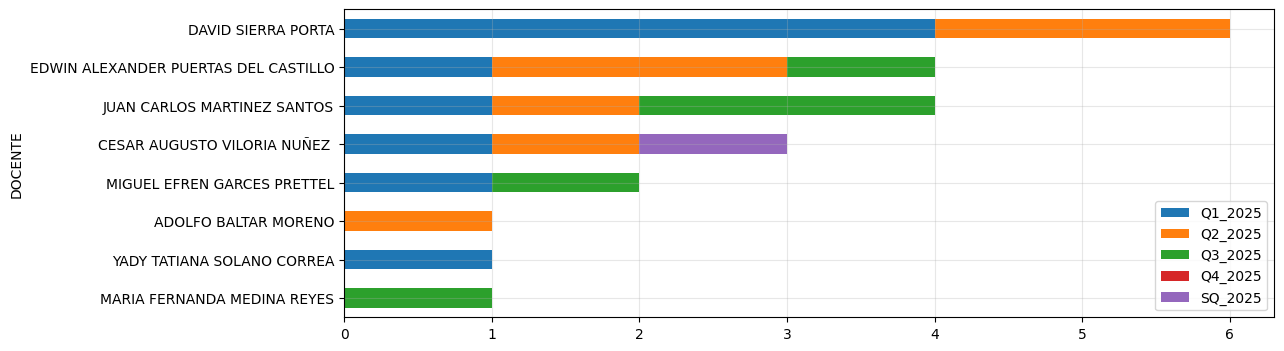

In [64]:
dat.set_index("DOCENTE")\
    .sort_values(by="Total 2025",ascending=True)[["Q1_2025","Q2_2025","Q3_2025","Q4_2025","SQ_2025"]]\
    .plot.barh(stacked=True, figsize=(12, 4))
plt.grid(alpha=0.3)
plt.savefig("ETD1.png",dpi=300,bbox_inches='tight')

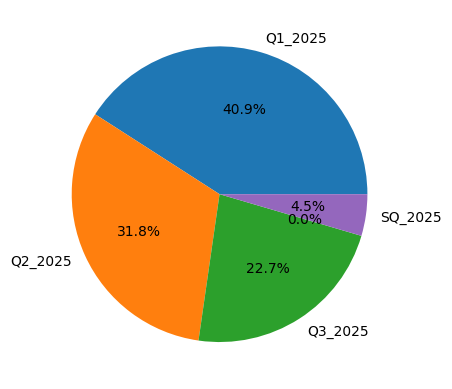

In [76]:
dat[["Q1_2025","Q2_2025","Q3_2025","Q4_2025","SQ_2025"]].T.sum(axis=1).plot.pie(autopct='%1.1f%%')
plt.savefig("ETD2.png",dpi=300,bbox_inches='tight')
plt.show()

# Scrip Scopus for publication records.
![EDT1](EDT1.png)
![EDT2]("EDT2.png)